# Q2 Analysis: Constitutional Isomer Set Classification

This notebook analyzes model performance on Q2 tasks (identifying whether a set of molecules are constitutional isomers) with:
- Accuracy, Precision, Recall, F1 metrics
- Performance by label (Yes vs No)
- Stratification by molecular properties (molecular weight, formula complexity)

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict, Counter
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from sklearn.metrics import confusion_matrix, classification_report

# Set style for plots - clean, no grid
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

custom_colors = ['#FF6B35', '#2E86AB', '#06A77D']  # Orange, Blue, Teal - high contrast

## Helper Functions

In [2]:
def get_molecular_weight(smiles):
    """Calculate molecular weight"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return Descriptors.MolWt(mol)

def get_molecular_formula(smiles):
    """Get molecular formula"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return rdMolDescriptors.CalcMolFormula(mol)

def count_elements_in_formula(formula):
    """Count number of unique elements in molecular formula"""
    if formula is None:
        return None
    
    # Parse formula (e.g., "C6H12O2" -> ["C", "H", "O"])
    import re
    elements = re.findall(r'([A-Z][a-z]?)', formula)
    return len(set(elements))

def count_atoms_in_formula(formula):
    """Count total number of atoms in molecular formula"""
    if formula is None:
        return None
    
    # Parse formula (e.g., "C6H12O2" -> 6+12+2=20)
    import re
    # Match element followed by optional number
    pattern = r'([A-Z][a-z]?)(\d*)'
    matches = re.findall(pattern, formula)
    
    total = 0
    for element, count in matches:
        if count == '':
            total += 1
        else:
            total += int(count)
    return total

def get_num_heavy_atoms(smiles):
    """Get number of heavy atoms"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return mol.GetNumHeavyAtoms()

## Load Data

In [3]:
# Load the dataset to get ground truth and metadata
dataset = []
with open('data/dataset_q2_balanced.jsonl', 'r') as f:
    for line in f:
        dataset.append(json.loads(line))

# Filter for Q2 tasks only
q2_dataset = [d for d in dataset if d['task'] == 'q2_isomer_set_yes_no']

# Create a lookup by instance ID
dataset_lookup = {d['id']: d for d in q2_dataset}

print(f"Total Q2 instances in dataset: {len(q2_dataset)}")
print(f"Tasks: {set(d['task'] for d in q2_dataset)}")

Total Q2 instances in dataset: 1000
Tasks: {'q2_isomer_set_yes_no'}


In [4]:
# Define the runs to analyze
run_files = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_parallel/q2_isomer_set_yes_no_q2_balanced.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_parallel/q2_isomer_set_yes_no_q2_balanced.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_parallel/q2_isomer_set_yes_no_q2_balanced.jsonl'),
]

# Load all runs
all_results = []

for model_name, file_path in run_files:
    if not Path(file_path).exists():
        print(f"Warning: {file_path} not found, skipping...")
        continue
    
    with open(file_path, 'r') as f:
        for line in f:
            result = json.loads(line)
            result['model_name'] = model_name
            all_results.append(result)

print(f"\nTotal results loaded: {len(all_results)}")
print(f"Models: {set(r['model_name'] for r in all_results)}")


Total results loaded: 3000
Models: {'gpt-5.2', 'claude-opus-4-5', 'gemini-3-pro-preview'}


## Compute Enriched Metrics

In [5]:
# Enrich results with molecular properties
enriched_results = []

for result in all_results:
    instance_id = result['id']
    
    # Get dataset info
    if instance_id not in dataset_lookup:
        print(f"Warning: {instance_id} not found in dataset")
        continue
    
    dataset_info = dataset_lookup[instance_id]
    
    # Extract prediction and gold label
    pred = result['score'].get('pred')
    gold = result['score'].get('gold')
    correct = result['score'].get('correct', False)
    
    # Calculate molecular properties from first molecule (all should be same formula for isomers)
    first_molecule = dataset_info['molecules'][0]
    
    mol_weight = get_molecular_weight(first_molecule)
    formula = get_molecular_formula(first_molecule)
    n_elements = count_elements_in_formula(formula)
    n_atoms = count_atoms_in_formula(formula)
    
    # Calculate average molecular properties across all molecules in the set
    all_weights = [get_molecular_weight(m) for m in dataset_info['molecules']]
    all_weights = [w for w in all_weights if w is not None]
    avg_mol_weight = np.mean(all_weights) if all_weights else None
    
    all_heavy_atoms = [get_num_heavy_atoms(m) for m in dataset_info['molecules']]
    all_heavy_atoms = [a for a in all_heavy_atoms if a is not None]
    avg_heavy_atoms = np.mean(all_heavy_atoms) if all_heavy_atoms else None
    
    # Get formula from metadata if available
    metadata_formula = dataset_info.get('metadata', {}).get('formula')
    if metadata_formula:
        formula = metadata_formula
    
    enriched = {
        'id': instance_id,
        'model': result['model_name'],
        'task': result['task'],
        'n_molecules': result['n_molecules'],
        'pred': pred,
        'gold': gold,
        'correct': correct,
        'molecular_weight': mol_weight,
        'avg_molecular_weight': avg_mol_weight,
        'formula': formula,
        'n_elements': n_elements,
        'n_atoms_formula': n_atoms,
        'avg_heavy_atoms': avg_heavy_atoms,
    }
    
    enriched_results.append(enriched)

# Convert to DataFrame
df = pd.DataFrame(enriched_results)

print(f"\nEnriched results: {len(df)} instances")
print(f"\nSample of enriched data:")
print(df.head())


Enriched results: 3000 instances

Sample of enriched data:
            id            model                  task  n_molecules pred gold  \
0  q2_n5_00001  claude-opus-4-5  q2_isomer_set_yes_no            5   No  Yes   
1  q2_n5_00002  claude-opus-4-5  q2_isomer_set_yes_no            5   No   No   
2  q2_n5_00003  claude-opus-4-5  q2_isomer_set_yes_no            5   No  Yes   
3  q2_n5_00004  claude-opus-4-5  q2_isomer_set_yes_no            5   No   No   
4  q2_n5_00005  claude-opus-4-5  q2_isomer_set_yes_no            5   No  Yes   

   correct  molecular_weight  avg_molecular_weight  formula  n_elements  \
0    False           227.927              227.9270  C5H8Br2           3   
1     True           122.982              120.4012  C4H4Cl2           3   
2    False           142.983              142.9830   C5H3Br           3   
3     True            74.510               77.2388   C3H3Cl           3   
4    False            70.066               70.0660    C4H3F           3   

   n_ato

In [6]:
# Overall statistics
print("=" * 80)
print("OVERALL STATISTICS")
print("=" * 80)

for model in df['model'].unique():
    subset = df[df['model'] == model]
    
    print(f"\n{model}:")
    print(f"  Total instances: {len(subset)}")
    print(f"  Overall Accuracy: {subset['correct'].mean():.3f}")
    print(f"  No response: {subset['pred'].isna().sum()} ({subset['pred'].isna().mean():.1%})")
    
    # Classification metrics
    valid_subset = subset[subset['pred'].notna()]
    if len(valid_subset) > 0:
        print(f"\n  Classification Report:")
        print(classification_report(valid_subset['gold'], valid_subset['pred'], 
                                     labels=['Yes', 'No'], zero_division=0))
        
        # Confusion matrix
        cm = confusion_matrix(valid_subset['gold'], valid_subset['pred'], labels=['Yes', 'No'])
        print(f"\n  Confusion Matrix:")
        print(f"              Predicted")
        print(f"              Yes    No")
        print(f"  Actual Yes  {cm[0,0]:4d}  {cm[0,1]:4d}")
        print(f"  Actual No   {cm[1,0]:4d}  {cm[1,1]:4d}")

OVERALL STATISTICS

claude-opus-4-5:
  Total instances: 1000
  Overall Accuracy: 0.712
  No response: 0 (0.0%)

  Classification Report:
              precision    recall  f1-score   support

         Yes       0.95      0.45      0.61       500
          No       0.64      0.98      0.77       500

    accuracy                           0.71      1000
   macro avg       0.80      0.71      0.69      1000
weighted avg       0.80      0.71      0.69      1000


  Confusion Matrix:
              Predicted
              Yes    No
  Actual Yes   223   277
  Actual No     11   489

gpt-5.2:
  Total instances: 1000
  Overall Accuracy: 0.501
  No response: 0 (0.0%)

  Classification Report:
              precision    recall  f1-score   support

         Yes       1.00      0.00      0.00       500
          No       0.50      1.00      0.67       500

    accuracy                           0.50      1000
   macro avg       0.75      0.50      0.34      1000
weighted avg       0.75      0.50  

## Visualizations

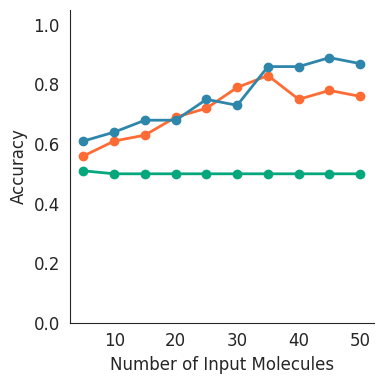

In [7]:
plt.rcParams['font.size'] = 12
fig, axes = plt.subplots(1,1, figsize=(4, 4))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

ax1 = axes
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['correct'].mean().reset_index()
    ax1.plot(grouped['n_molecules'], grouped['correct'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax1.set_xlabel('Number of Input Molecules')
ax1.set_ylabel('Accuracy')
# ax1.set_title('Overall Accuracy vs Number of Molecules')
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)
# fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False)
plt.tight_layout()
plt.show()


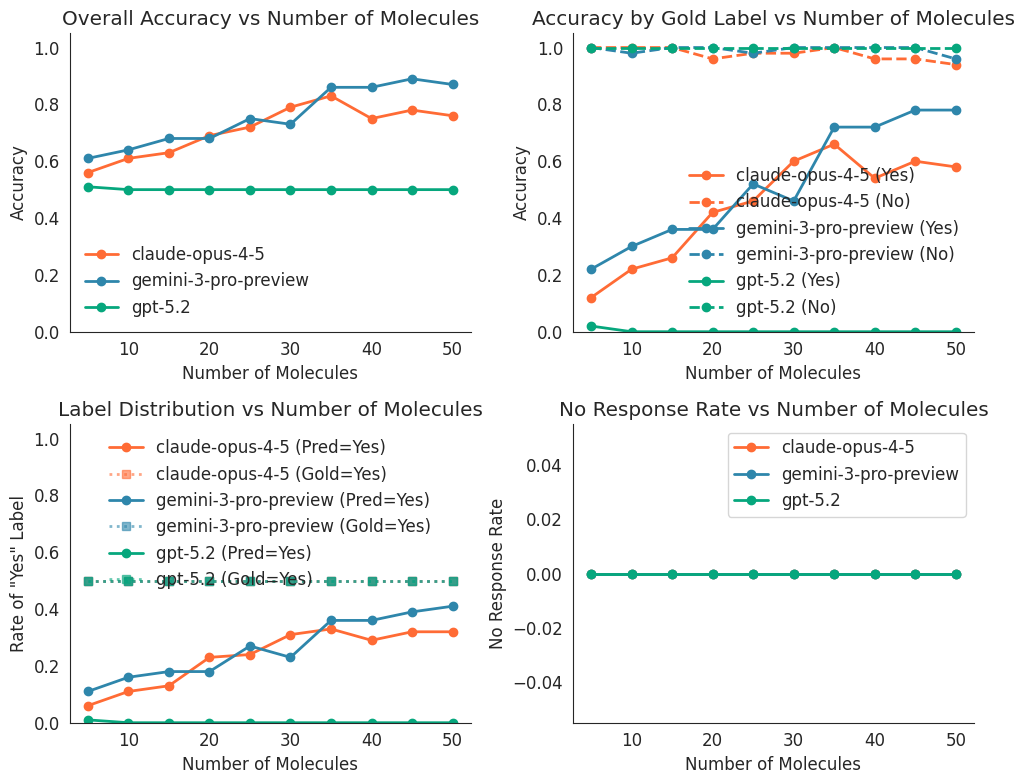

In [8]:
# Stratify by n_molecules
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

# Overall accuracy by n_molecules
ax1 = axes[0, 0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['correct'].mean().reset_index()
    ax1.plot(grouped['n_molecules'], grouped['correct'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax1.set_xlabel('Number of Molecules')
ax1.set_ylabel('Accuracy')
ax1.set_title('Overall Accuracy vs Number of Molecules')
ax1.legend(frameon=False)
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

# Accuracy by gold label and n_molecules
ax2 = axes[0, 1]
for model in models:
    for gold_label in ['Yes', 'No']:
        subset = df[(df['model'] == model) & (df['gold'] == gold_label)]
        grouped = subset.groupby('n_molecules')['correct'].mean().reset_index()
        linestyle = '-' if gold_label == 'Yes' else '--'
        ax2.plot(grouped['n_molecules'], grouped['correct'], marker='o', 
                label=f"{model} ({gold_label})", linestyle=linestyle, linewidth=2,
                color=color_map[model])
ax2.set_xlabel('Number of Molecules')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy by Gold Label vs Number of Molecules')
ax2.legend(frameon=False)
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)

# Distribution of predictions by n_molecules
ax3 = axes[1, 0]
for model in models:
    subset = df[df['model'] == model]
    # Calculate percentage of 'Yes' predictions
    valid_subset = subset[subset['pred'].notna()]
    grouped = valid_subset.groupby('n_molecules')['pred'].apply(lambda x: (x == 'Yes').mean()).reset_index()
    grouped.columns = ['n_molecules', 'yes_rate']
    ax3.plot(grouped['n_molecules'], grouped['yes_rate'], marker='o', label=f"{model} (Pred=Yes)", 
             linewidth=2, color=color_map[model])
    
    # Gold label distribution
    grouped_gold = subset.groupby('n_molecules')['gold'].apply(lambda x: (x == 'Yes').mean()).reset_index()
    grouped_gold.columns = ['n_molecules', 'yes_rate']
    ax3.plot(grouped_gold['n_molecules'], grouped_gold['yes_rate'], marker='s', 
            label=f"{model} (Gold=Yes)", linestyle=':', linewidth=2, alpha=0.6,
            color=color_map[model])
ax3.set_xlabel('Number of Molecules')
ax3.set_ylabel('Rate of "Yes" Label')
ax3.set_title('Label Distribution vs Number of Molecules')
ax3.legend(frameon=False)
ax3.set_ylim([0, 1.05])
sns.despine(ax=ax3)

# No response rate by n_molecules
ax4 = axes[1, 1]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_molecules')['pred'].apply(lambda x: x.isna().mean()).reset_index()
    grouped.columns = ['n_molecules', 'no_response_rate']
    ax4.plot(grouped['n_molecules'], grouped['no_response_rate'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax4.set_xlabel('Number of Molecules')
ax4.set_ylabel('No Response Rate')
ax4.set_title('No Response Rate vs Number of Molecules')
ax4.legend()
sns.despine(ax=ax4)

plt.tight_layout()
plt.show()

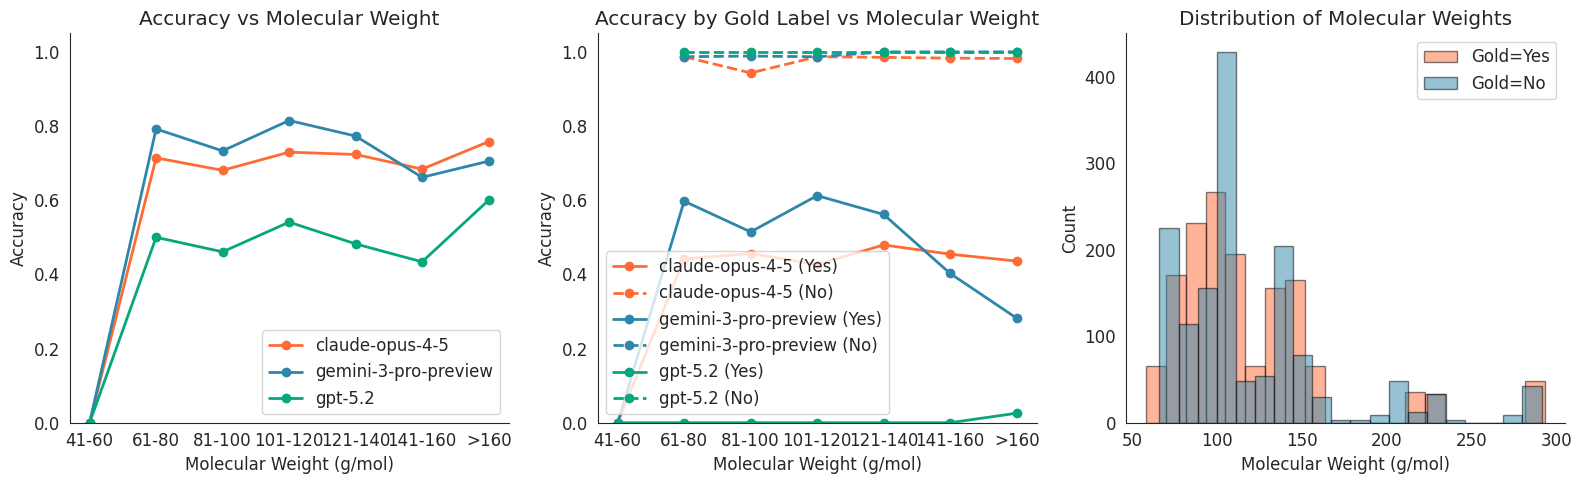

In [9]:
# Stratify by molecular weight
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}

# Create bins for molecular weight
df['mol_weight_bin'] = pd.cut(df['avg_molecular_weight'], 
                               bins=[0, 40, 60, 80, 100, 120, 140, 160, 1000], 
                               labels=['≤40', '41-60', '61-80', '81-100', '101-120', '121-140', '141-160', '>160'])

# Accuracy by molecular weight
ax1 = axes[0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('mol_weight_bin', observed=True)['correct'].mean().reset_index()
    ax1.plot(grouped['mol_weight_bin'], grouped['correct'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax1.set_xlabel('Molecular Weight (g/mol)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Molecular Weight')
ax1.legend()
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

# Accuracy by gold label and molecular weight
ax2 = axes[1]
for model in models:
    for gold_label in ['Yes', 'No']:
        subset = df[(df['model'] == model) & (df['gold'] == gold_label)]
        grouped = subset.groupby('mol_weight_bin', observed=True)['correct'].mean().reset_index()
        linestyle = '-' if gold_label == 'Yes' else '--'
        ax2.plot(grouped['mol_weight_bin'], grouped['correct'], marker='o', 
                label=f"{model} ({gold_label})", linestyle=linestyle, linewidth=2,
                color=color_map[model])
ax2.set_xlabel('Molecular Weight (g/mol)')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy by Gold Label vs Molecular Weight')
ax2.legend()
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)

# Distribution of molecular weights
ax3 = axes[2]
label_colors = {'Yes': custom_colors[0], 'No': custom_colors[1]}
for gold_label in ['Yes', 'No']:
    subset = df[df['gold'] == gold_label]
    ax3.hist(subset['avg_molecular_weight'].dropna(), bins=20, alpha=0.5, 
            label=f"Gold={gold_label}", edgecolor='black', color=label_colors[gold_label])
ax3.set_xlabel('Molecular Weight (g/mol)')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Molecular Weights')
ax3.legend()
sns.despine(ax=ax3)

plt.tight_layout()
plt.show()

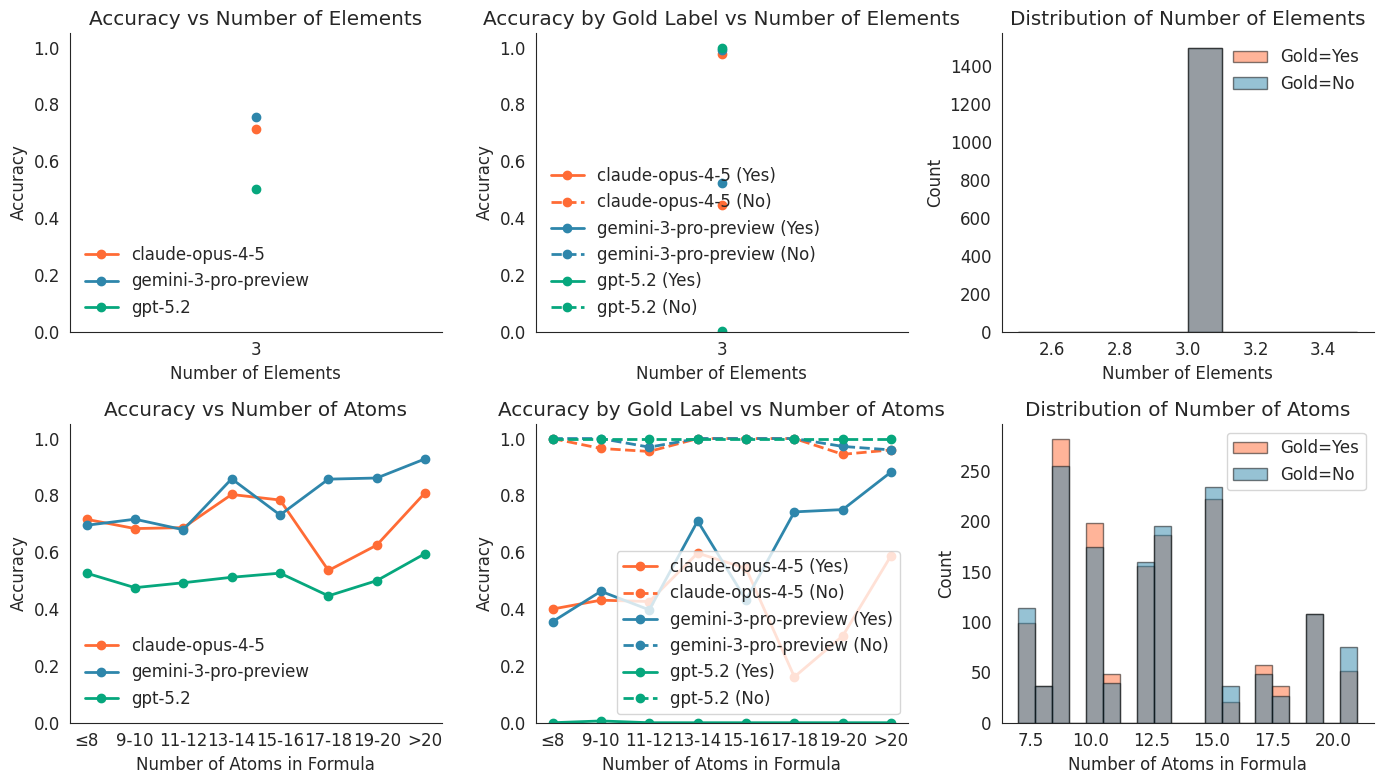

In [10]:
# Stratify by formula complexity
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Create color mapping for models
models = sorted(df['model'].unique())
color_map = {model: custom_colors[i % len(custom_colors)] for i, model in enumerate(models)}
label_colors = {'Yes': custom_colors[0], 'No': custom_colors[1]}

# Create bins for n_elements and n_atoms
df['n_elements_bin'] = pd.cut(df['n_elements'], bins=[0, 2, 3, 4, 100], labels=['≤2', '3', '4', '>4'])
df['n_atoms_bin'] = pd.cut(df['n_atoms_formula'], bins=[0, 8, 10, 12, 14, 16, 18, 20, 1000], labels=['≤8', '9-10', '11-12', '13-14', '15-16', '17-18', '19-20', '>20'])

# Accuracy by n_elements
ax1 = axes[0, 0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_elements_bin', observed=True)['correct'].mean().reset_index()
    ax1.plot(grouped['n_elements_bin'], grouped['correct'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax1.set_xlabel('Number of Elements')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Number of Elements')
ax1.legend(frameon=False)
ax1.set_ylim([0, 1.05])
sns.despine(ax=ax1)

# Accuracy by n_elements and gold label
ax2 = axes[0, 1]
for model in models:
    for gold_label in ['Yes', 'No']:
        subset = df[(df['model'] == model) & (df['gold'] == gold_label)]
        grouped = subset.groupby('n_elements_bin', observed=True)['correct'].mean().reset_index()
        linestyle = '-' if gold_label == 'Yes' else '--'
        ax2.plot(grouped['n_elements_bin'], grouped['correct'], marker='o', 
                label=f"{model} ({gold_label})", linestyle=linestyle, linewidth=2,
                color=color_map[model])
ax2.set_xlabel('Number of Elements')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy by Gold Label vs Number of Elements')
ax2.legend(frameon=False)
ax2.set_ylim([0, 1.05])
sns.despine(ax=ax2)

# Distribution of n_elements
ax3 = axes[0, 2]
for gold_label in ['Yes', 'No']:
    subset = df[df['gold'] == gold_label]
    ax3.hist(subset['n_elements'].dropna(), bins=10, alpha=0.5, 
            label=f"Gold={gold_label}", edgecolor='black', color=label_colors[gold_label])
ax3.set_xlabel('Number of Elements')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Number of Elements')
ax3.legend(frameon=False)
sns.despine(ax=ax3)

# Accuracy by n_atoms
ax4 = axes[1, 0]
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_atoms_bin', observed=True)['correct'].mean().reset_index()
    ax4.plot(grouped['n_atoms_bin'], grouped['correct'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax4.set_xlabel('Number of Atoms in Formula')
ax4.set_ylabel('Accuracy')
ax4.set_title('Accuracy vs Number of Atoms')
ax4.legend(frameon=False)
ax4.set_ylim([0, 1.05])
sns.despine(ax=ax4)

# Accuracy by n_atoms and gold label
ax5 = axes[1, 1]
for model in models:
    for gold_label in ['Yes', 'No']:
        subset = df[(df['model'] == model) & (df['gold'] == gold_label)]
        grouped = subset.groupby('n_atoms_bin', observed=True)['correct'].mean().reset_index()
        linestyle = '-' if gold_label == 'Yes' else '--'
        ax5.plot(grouped['n_atoms_bin'], grouped['correct'], marker='o', 
                label=f"{model} ({gold_label})", linestyle=linestyle, linewidth=2,
                color=color_map[model])
ax5.set_xlabel('Number of Atoms in Formula')
ax5.set_ylabel('Accuracy')
ax5.set_title('Accuracy by Gold Label vs Number of Atoms')
ax5.legend()
ax5.set_ylim([0, 1.05])
sns.despine(ax=ax5)

# Distribution of n_atoms
ax6 = axes[1, 2]
for gold_label in ['Yes', 'No']:
    subset = df[df['gold'] == gold_label]
    ax6.hist(subset['n_atoms_formula'].dropna(), bins=20, alpha=0.5, 
            label=f"Gold={gold_label}", edgecolor='black', color=label_colors[gold_label])
ax6.set_xlabel('Number of Atoms in Formula')
ax6.set_ylabel('Count')
ax6.set_title('Distribution of Number of Atoms')
ax6.legend()
sns.despine(ax=ax6)

plt.tight_layout()
plt.show()

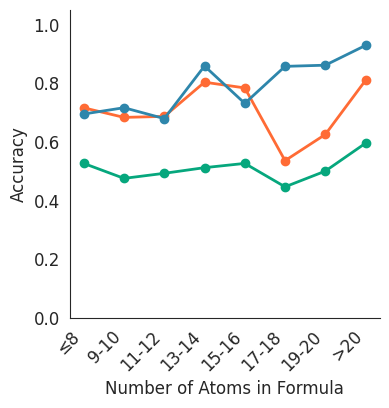

In [18]:
# Accuracy by n_atoms
fig, axes = plt.subplots(1,1, figsize=(4,4))
ax4 = axes
for model in models:
    subset = df[df['model'] == model]
    grouped = subset.groupby('n_atoms_bin', observed=True)['correct'].mean().reset_index()
    ax4.plot(grouped['n_atoms_bin'], grouped['correct'], marker='o', label=model, 
             linewidth=2, color=color_map[model])
ax4.set_xlabel('Number of Atoms in Formula')
ax4.set_ylabel('Accuracy')
# ax4.set_title('Accuracy vs Number of Atoms')
# ax4.legend(frameon=False)
ax4.set_ylim([0, 1.05])
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
sns.despine(ax=ax4)

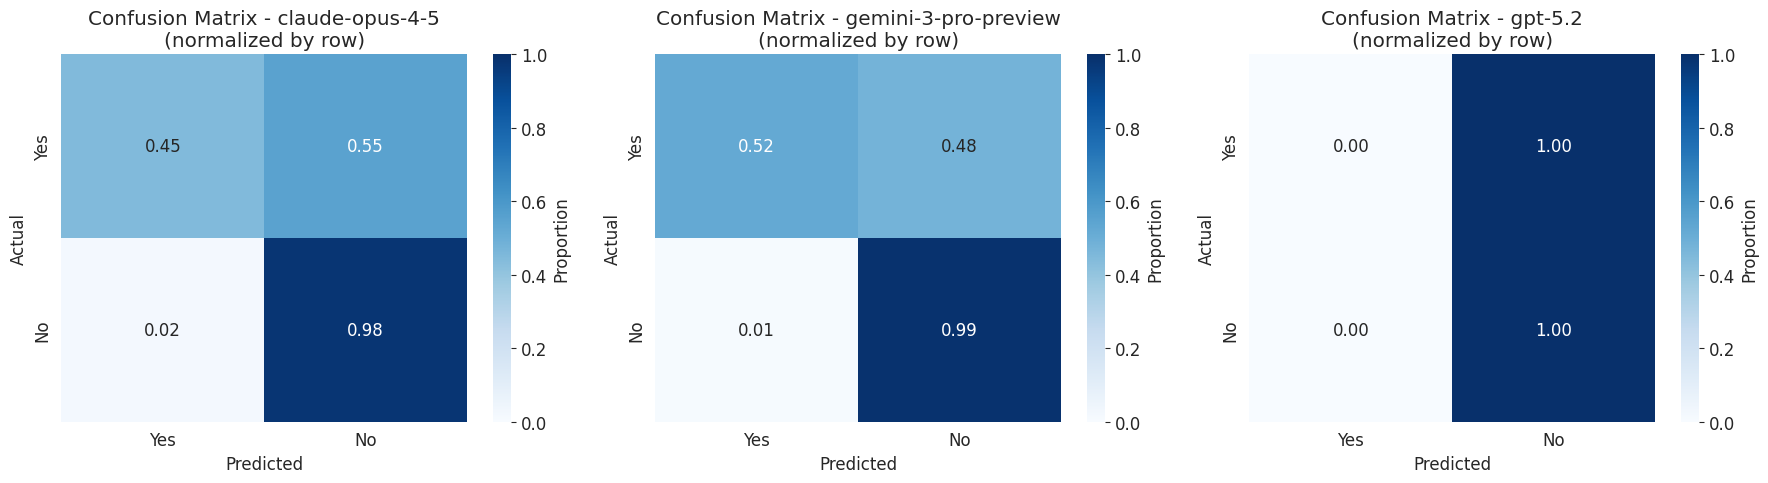

In [11]:
# Confusion matrices as heatmaps
models = sorted(df['model'].unique())
fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 5))

if len(models) == 1:
    axes = [axes]

for idx, model in enumerate(models):
    subset = df[(df['model'] == model) & (df['pred'].notna())]
    
    if len(subset) > 0:
        cm = confusion_matrix(subset['gold'], subset['pred'], labels=['Yes', 'No'])
        
        # Normalize by row (gold label)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        ax = axes[idx]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
                   xticklabels=['Yes', 'No'], yticklabels=['Yes', 'No'],
                   cbar_kws={'label': 'Proportion'}, ax=ax, vmin=0, vmax=1)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix - {model}\n(normalized by row)')
        sns.despine(ax=ax, left=True, bottom=True)

plt.tight_layout()
plt.show()

## Detailed Performance Tables

In [12]:
# Create detailed table stratified by n_molecules
summary_by_n = []

for model in sorted(df['model'].unique()):
    for n_mol in sorted(df['n_molecules'].unique()):
        subset = df[(df['model'] == model) & (df['n_molecules'] == n_mol)]
        if len(subset) == 0:
            continue
        
        # Overall metrics
        valid_subset = subset[subset['pred'].notna()]
        
        # Accuracy by gold label
        acc_yes = subset[subset['gold'] == 'Yes']['correct'].mean() if len(subset[subset['gold'] == 'Yes']) > 0 else np.nan
        acc_no = subset[subset['gold'] == 'No']['correct'].mean() if len(subset[subset['gold'] == 'No']) > 0 else np.nan
        
        summary_by_n.append({
            'Model': model,
            'N_molecules': n_mol,
            'Count': len(subset),
            'Accuracy': f"{subset['correct'].mean():.3f}",
            'Acc_Yes': f"{acc_yes:.3f}" if not np.isnan(acc_yes) else 'N/A',
            'Acc_No': f"{acc_no:.3f}" if not np.isnan(acc_no) else 'N/A',
            'No_Response': f"{subset['pred'].isna().mean():.3f}",
        })

summary_by_n_df = pd.DataFrame(summary_by_n)
print("\n" + "=" * 100)
print("PERFORMANCE BY NUMBER OF MOLECULES")
print("=" * 100)
print(summary_by_n_df.to_string(index=False))


PERFORMANCE BY NUMBER OF MOLECULES
               Model  N_molecules  Count Accuracy Acc_Yes Acc_No No_Response
     claude-opus-4-5            5    100    0.560   0.120  1.000       0.000
     claude-opus-4-5           10    100    0.610   0.220  1.000       0.000
     claude-opus-4-5           15    100    0.630   0.260  1.000       0.000
     claude-opus-4-5           20    100    0.690   0.420  0.960       0.000
     claude-opus-4-5           25    100    0.720   0.460  0.980       0.000
     claude-opus-4-5           30    100    0.790   0.600  0.980       0.000
     claude-opus-4-5           35    100    0.830   0.660  1.000       0.000
     claude-opus-4-5           40    100    0.750   0.540  0.960       0.000
     claude-opus-4-5           45    100    0.780   0.600  0.960       0.000
     claude-opus-4-5           50    100    0.760   0.580  0.940       0.000
gemini-3-pro-preview            5    100    0.610   0.220  1.000       0.000
gemini-3-pro-preview           10    100

In [13]:
# Create detailed table stratified by molecular properties
summary_by_props = []

for model in sorted(df['model'].unique()):
    # By molecular weight
    for mw_bin in df['mol_weight_bin'].cat.categories:
        subset = df[(df['model'] == model) & (df['mol_weight_bin'] == mw_bin)]
        if len(subset) == 0:
            continue
        
        summary_by_props.append({
            'Model': model,
            'Property': 'Mol_Weight',
            'Bin': str(mw_bin),
            'Count': len(subset),
            'Accuracy': f"{subset['correct'].mean():.3f}",
        })
    
    # By n_elements
    for elem_bin in df['n_elements_bin'].cat.categories:
        subset = df[(df['model'] == model) & (df['n_elements_bin'] == elem_bin)]
        if len(subset) == 0:
            continue
        
        summary_by_props.append({
            'Model': model,
            'Property': 'N_Elements',
            'Bin': str(elem_bin),
            'Count': len(subset),
            'Accuracy': f"{subset['correct'].mean():.3f}",
        })
    
    # By n_atoms
    for atom_bin in df['n_atoms_bin'].cat.categories:
        subset = df[(df['model'] == model) & (df['n_atoms_bin'] == atom_bin)]
        if len(subset) == 0:
            continue
        
        summary_by_props.append({
            'Model': model,
            'Property': 'N_Atoms',
            'Bin': str(atom_bin),
            'Count': len(subset),
            'Accuracy': f"{subset['correct'].mean():.3f}",
        })

summary_by_props_df = pd.DataFrame(summary_by_props)
print("\n" + "=" * 100)
print("PERFORMANCE BY MOLECULAR PROPERTIES")
print("=" * 100)
print(summary_by_props_df.to_string(index=False))


PERFORMANCE BY MOLECULAR PROPERTIES
               Model   Property     Bin  Count Accuracy
     claude-opus-4-5 Mol_Weight   41-60      2    0.000
     claude-opus-4-5 Mol_Weight   61-80    154    0.714
     claude-opus-4-5 Mol_Weight  81-100    191    0.681
     claude-opus-4-5 Mol_Weight 101-120    281    0.730
     claude-opus-4-5 Mol_Weight 121-140    141    0.723
     claude-opus-4-5 Mol_Weight 141-160    136    0.684
     claude-opus-4-5 Mol_Weight    >160     95    0.758
     claude-opus-4-5 N_Elements       3   1000    0.712
     claude-opus-4-5    N_Atoms      ≤8     95    0.716
     claude-opus-4-5    N_Atoms    9-10    303    0.683
     claude-opus-4-5    N_Atoms   11-12    134    0.687
     claude-opus-4-5    N_Atoms   13-14    127    0.803
     claude-opus-4-5    N_Atoms   15-16    171    0.784
     claude-opus-4-5    N_Atoms   17-18     56    0.536
     claude-opus-4-5    N_Atoms   19-20     72    0.625
     claude-opus-4-5    N_Atoms     >20     42    0.810
gemini-3-pr

In [14]:
# Export enriched results to CSV for further analysis
output_path = 'analysis_results/q2_enriched_results.csv'
Path('analysis_results').mkdir(exist_ok=True)
df.to_csv(output_path, index=False)
print(f"\nEnriched results exported to: {output_path}")

# Export summary tables
summary_by_n_df.to_csv('analysis_results/q2_summary_by_n_molecules.csv', index=False)
summary_by_props_df.to_csv('analysis_results/q2_summary_by_properties.csv', index=False)
print("Summary tables exported to analysis_results/")


Enriched results exported to: analysis_results/q2_enriched_results.csv
Summary tables exported to analysis_results/
